In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
from sklearn import datasets # for swiss roll dataset
import mpl_toolkits.mplot3d.axes3d as p3 # 3D plotting

---
### 1K-Point Swiss Roll

In [3]:
X, t = datasets.make_swiss_roll(n_samples=1000, noise=0.0, random_state=18)

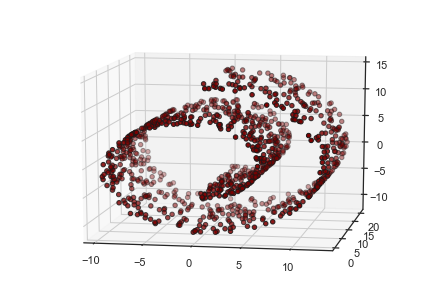

In [4]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [5]:
swiss_1k = sc.AnnData(X=X) # initialize AnnData
swiss_1k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_1k

AnnData object with n_obs × n_vars = 1000 × 3 
    obs: 'pos'

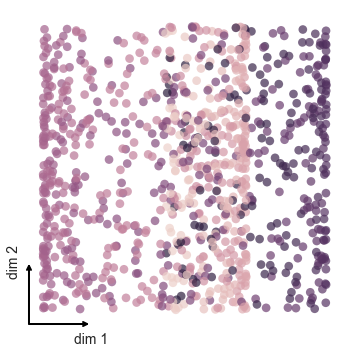

In [6]:
# 'top down' view
plot_DR(swiss_1k.X, color=swiss_1k.obs['pos'])

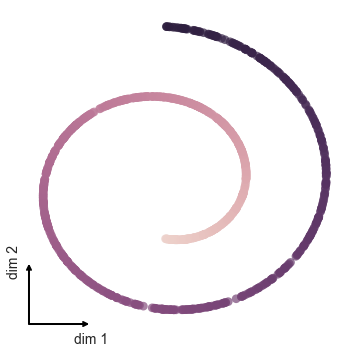

In [7]:
# 'front' view
plot_DR(swiss_1k.X[:,[0,2]], color=swiss_1k.obs['pos'])

In [8]:
# perform PCA
sc.tl.pca(swiss_1k, n_comps=2)

In [9]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_1k, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

In [10]:
# perform Louvain clustering
sc.tl.louvain(swiss_1k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_1k.obs['clusterID'] = 'cluster_' + swiss_1k.obs['louvain'].astype(str)

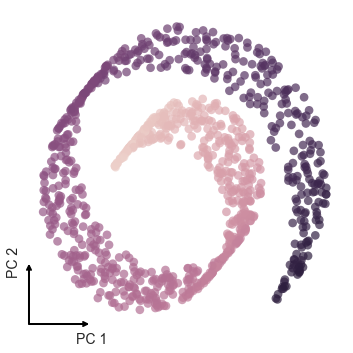

In [11]:
plot_DR(swiss_1k.obsm['X_pca'], color=swiss_1k.obs['pos'], dim_name='PC')

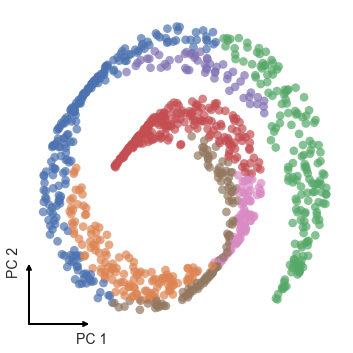

In [12]:
plot_DR(swiss_1k.obsm['X_pca'], color=swiss_1k.obs['clusterID'], dim_name='PC')

In [14]:
# perform UMAP
sc.tl.umap(swiss_1k)

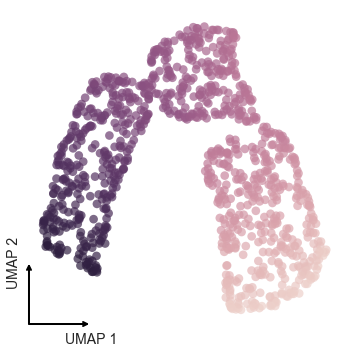

In [15]:
plot_DR(swiss_1k.obsm['X_umap'], color=swiss_1k.obs['pos'], dim_name='UMAP')

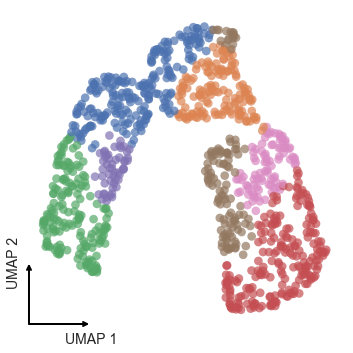

In [16]:
plot_DR(swiss_1k.obsm['X_umap'], color=swiss_1k.obs['clusterID'], dim_name='UMAP')

In [17]:
# perform t-SNE
sc.tl.tsne(swiss_1k, use_rep='X', perplexity=30)

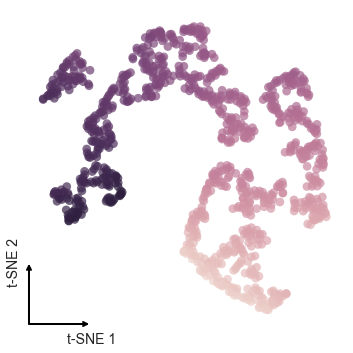

In [18]:
plot_DR(swiss_1k.obsm['X_tsne'], color=swiss_1k.obs['pos'], dim_name='t-SNE')

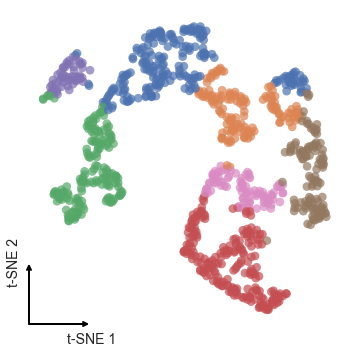

In [19]:
plot_DR(swiss_1k.obsm['X_tsne'], color=swiss_1k.obs['clusterID'], dim_name='t-SNE')

In [20]:
%%time
# save distance matrices in AnnData object for easy access
swiss_1k.uns['tsne_distance'] = pdist(swiss_1k.obsm['X_tsne'])
swiss_1k.uns['umap_distance'] = pdist(swiss_1k.obsm['X_umap'])
swiss_1k.uns['pca_distance'] = pdist(swiss_1k.obsm['X_pca'])
swiss_1k.uns['native_distance'] = pdist(swiss_1k.X)

CPU times: user 5.38 ms, sys: 1.39 ms, total: 6.77 ms
Wall time: 5.72 ms


In [21]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['pca_distance'])

CPU times: user 604 ms, sys: 83.3 ms, total: 687 ms
Wall time: 271 ms


R: 0.8567
EMD: 0.0386
CPU times: user 507 ms, sys: 35.3 ms, total: 542 ms
Wall time: 324 ms


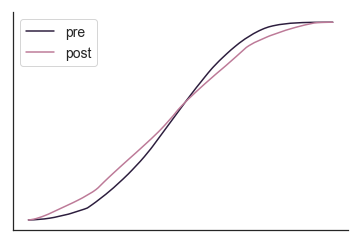

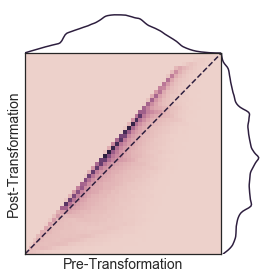

In [22]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [23]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['tsne_distance'])

CPU times: user 597 ms, sys: 87 ms, total: 684 ms
Wall time: 270 ms


R: 0.3863
EMD: 0.0488
CPU times: user 503 ms, sys: 33.5 ms, total: 537 ms
Wall time: 318 ms


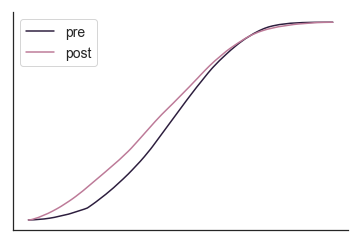

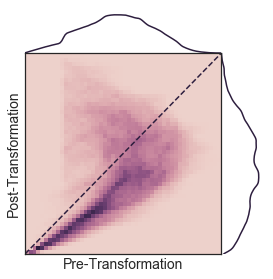

In [24]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [25]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_1k.uns['native_distance'], post=swiss_1k.uns['umap_distance'])

CPU times: user 592 ms, sys: 85 ms, total: 677 ms
Wall time: 263 ms


R: 0.3381
EMD: 0.0529
CPU times: user 507 ms, sys: 37.6 ms, total: 545 ms
Wall time: 326 ms


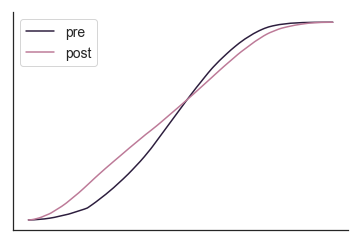

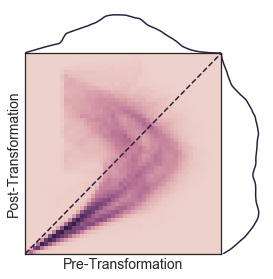

In [26]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

---
### 10K-Point Swiss Roll

In [27]:
X, t = datasets.make_swiss_roll(n_samples=10000, noise=0.0, random_state=18)

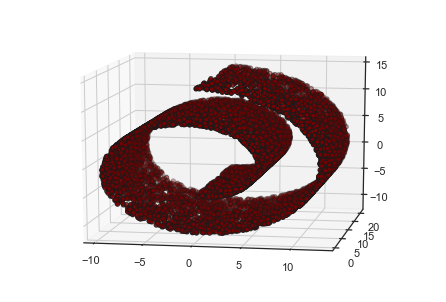

In [28]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [29]:
swiss_10k = sc.AnnData(X=X) # initialize AnnData
swiss_10k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_10k

AnnData object with n_obs × n_vars = 10000 × 3 
    obs: 'pos'

In [30]:
# perform PCA
sc.tl.pca(swiss_10k, n_comps=2)

In [31]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_10k, n_neighbors=100, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

In [33]:
# perform Louvain clustering
sc.tl.louvain(swiss_10k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_10k.obs['clusterID'] = 'cluster_' + swiss_10k.obs['louvain'].astype(str)

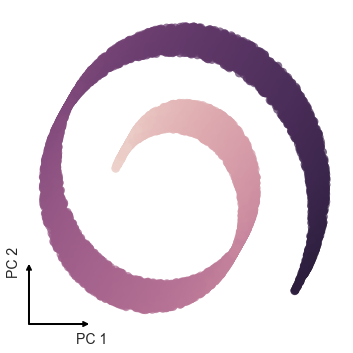

In [34]:
plot_DR(swiss_10k.obsm['X_pca'], color=swiss_10k.obs['pos'], dim_name='PC')

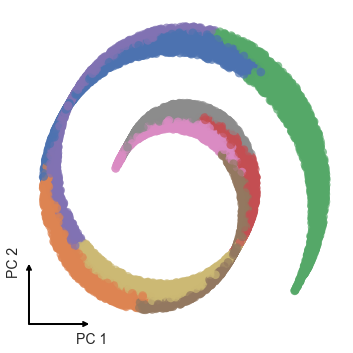

In [35]:
plot_DR(swiss_10k.obsm['X_pca'], color=swiss_10k.obs['clusterID'], dim_name='PC')

In [36]:
# perform UMAP
sc.tl.umap(swiss_10k)

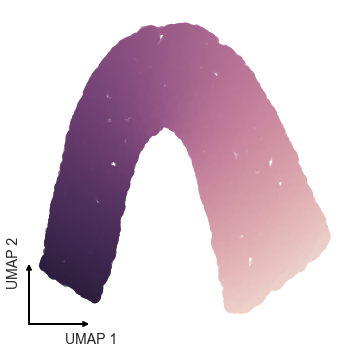

In [37]:
plot_DR(swiss_10k.obsm['X_umap'], color=swiss_10k.obs['pos'], dim_name='UMAP')

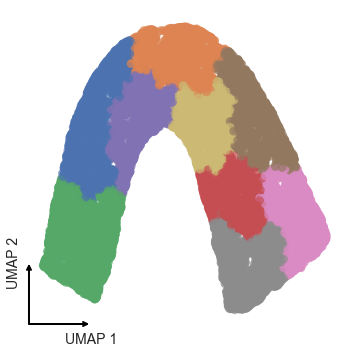

In [38]:
plot_DR(swiss_10k.obsm['X_umap'], color=swiss_10k.obs['clusterID'], dim_name='UMAP')

In [39]:
# perform t-SNE
sc.tl.tsne(swiss_10k, use_rep='X', perplexity=100)

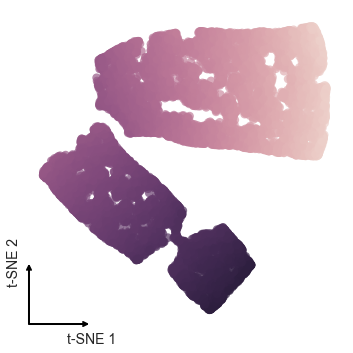

In [40]:
plot_DR(swiss_10k.obsm['X_tsne'], color=swiss_10k.obs['pos'], dim_name='t-SNE')

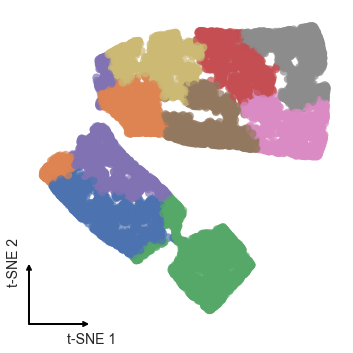

In [41]:
plot_DR(swiss_10k.obsm['X_tsne'], color=swiss_10k.obs['clusterID'], dim_name='t-SNE')

In [42]:
%%time
# save distance matrices in AnnData object for easy access
swiss_10k.uns['tsne_distance'] = pdist(swiss_10k.obsm['X_tsne'])
swiss_10k.uns['umap_distance'] = pdist(swiss_10k.obsm['X_umap'])
swiss_10k.uns['pca_distance'] = pdist(swiss_10k.obsm['X_pca'])
swiss_10k.uns['native_distance'] = pdist(swiss_10k.X)

CPU times: user 594 ms, sys: 229 ms, total: 823 ms
Wall time: 823 ms


In [43]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['pca_distance'])

CPU times: user 42.8 s, sys: 2.02 s, total: 44.8 s
Wall time: 44.3 s


R: 0.8512
EMD: 0.051
CPU times: user 25.3 s, sys: 1.84 s, total: 27.2 s
Wall time: 27 s


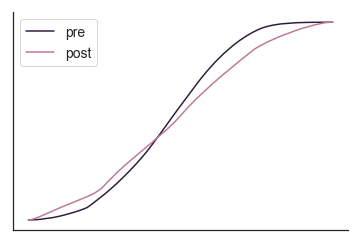

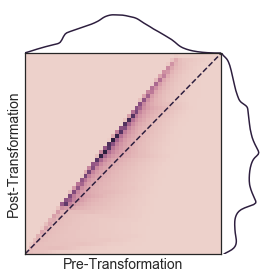

In [44]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [45]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['tsne_distance'])

CPU times: user 42.4 s, sys: 1.78 s, total: 44.2 s
Wall time: 43.6 s


R: 0.3767
EMD: 0.0459
CPU times: user 24.5 s, sys: 1.42 s, total: 25.9 s
Wall time: 25.7 s


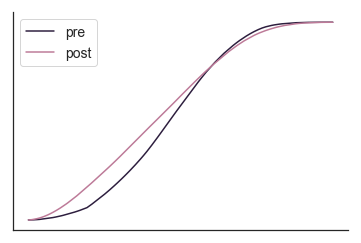

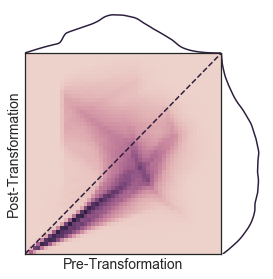

In [46]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [47]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_10k.uns['native_distance'], post=swiss_10k.uns['umap_distance'])

CPU times: user 41 s, sys: 1.7 s, total: 42.7 s
Wall time: 42.1 s


R: 0.3409
EMD: 0.0627
CPU times: user 24.9 s, sys: 1.68 s, total: 26.6 s
Wall time: 26.4 s


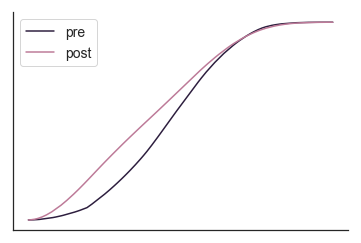

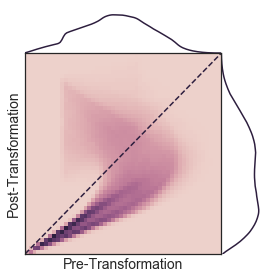

In [48]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

---
### 100K-Point Swiss Roll

In [49]:
X, t = datasets.make_swiss_roll(n_samples=100000, noise=0.0, random_state=18)

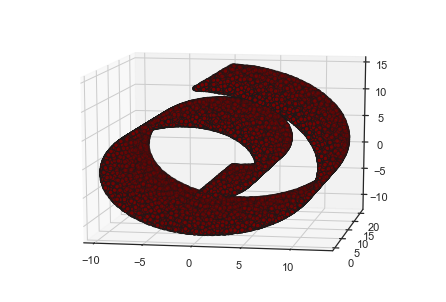

In [50]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(12, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color=plt.cm.jet(t), s=20, edgecolor='k')

In [51]:
swiss_100k = sc.AnnData(X=X) # initialize AnnData
swiss_100k.obs['pos'] = t # add univariate position according to main dim of manifold to .obs

swiss_100k

AnnData object with n_obs × n_vars = 100000 × 3 
    obs: 'pos'

In [52]:
# perform PCA
sc.tl.pca(swiss_100k, n_comps=2)

In [53]:
# create neighborhood graphs from PCA results for UMAP and Louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(swiss_100k, n_neighbors=300, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [54]:
%%time
# perform Louvain clustering
sc.tl.louvain(swiss_100k, resolution=0.5, key_added='louvain', random_state=18, copy=False)
# put cluster names in string column of .obs for plotting
swiss_100k.obs['clusterID'] = 'cluster_' + swiss_100k.obs['louvain'].astype(str)

CPU times: user 5min, sys: 1.87 s, total: 5min 2s
Wall time: 5min 1s


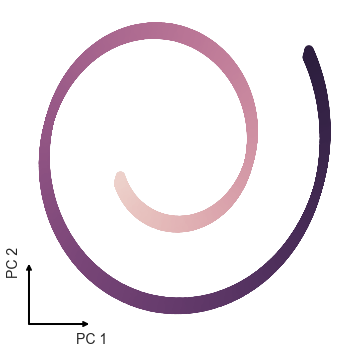

In [55]:
plot_DR(swiss_100k.obsm['X_pca'], color=swiss_100k.obs['pos'], dim_name='PC')

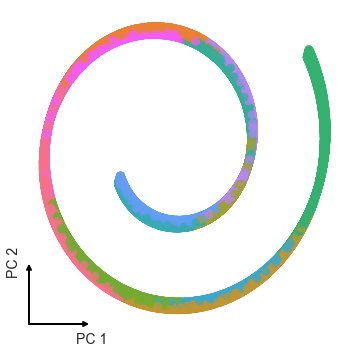

In [56]:
plot_DR(swiss_100k.obsm['X_pca'], color=swiss_100k.obs['clusterID'], dim_name='PC')

In [57]:
# perform UMAP
%time sc.tl.umap(swiss_100k)

CPU times: user 5min 16s, sys: 13.1 s, total: 5min 30s
Wall time: 2min 29s


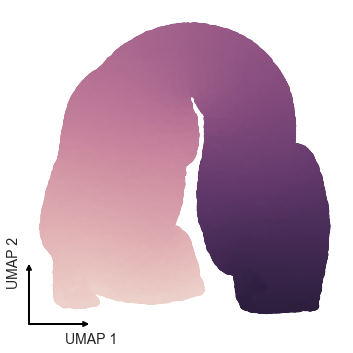

In [58]:
plot_DR(swiss_100k.obsm['X_umap'], color=swiss_100k.obs['pos'], dim_name='UMAP')

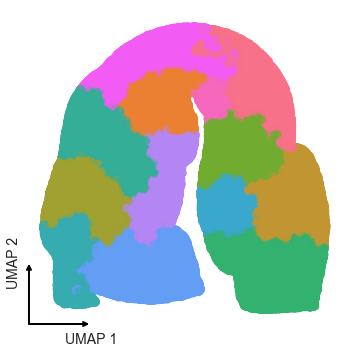

In [59]:
plot_DR(swiss_100k.obsm['X_umap'], color=swiss_100k.obs['clusterID'], dim_name='UMAP')

In [ ]:
# perform t-SNE
%time sc.tl.tsne(swiss_100k, use_rep='X', perplexity=100)

In [ ]:
plot_DR(swiss_100k.obsm['X_tsne'], color=swiss_100k.obs['pos'], dim_name='t-SNE')

In [ ]:
plot_DR(swiss_100k.obsm['X_tsne'], color=swiss_100k.obs['clusterID'], dim_name='t-SNE')

In [42]:
%%time
# save distance matrices in AnnData object for easy access
swiss_100k.uns['tsne_distance'] = pdist(swiss_100k.obsm['X_tsne'])
swiss_100k.uns['umap_distance'] = pdist(swiss_100k.obsm['X_umap'])
swiss_100k.uns['pca_distance'] = pdist(swiss_100k.obsm['X_pca'])
swiss_100k.uns['native_distance'] = pdist(swiss_100k.X)

CPU times: user 594 ms, sys: 229 ms, total: 823 ms
Wall time: 823 ms


In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['pca_distance'])

In [ ]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['tsne_distance'])

In [ ]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [ ]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=swiss_100k.uns['native_distance'], post=swiss_100k.uns['umap_distance'])

In [ ]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)